# Quantity base policy: price elasticity of carbon in MERGE

In [1]:
import pandas as pd
import pandas.io.excel
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pytz
import os
import patsy #for spline regression
import scipy #for non-negative least square 
import scipy as sp 
from scipy import stats
from scipy.optimize import nnls
from numpy.linalg import inv #for matrix and statistics
import scipy as sp
import math
import statsmodels.api as sm
%matplotlib inline

In [2]:
#define main directory
mainDir = 'C:/Users/Admin/Documents/xxx/Profession/EnergyProject/EMF/CarbonElasticity'

As we modify codes as explained earlier, we can run multiple scenarios in MERGE using studies.xls. Note that by our set up, we need to run scenarios in two batches. The first batch is one without any modification on carbon accounting. That is, all carbon is accounted for carbon cap. The second batch is one with modification on carbon accounting. That is, only fossil fuel carbon emission is accounted for carbon cap.

We measure both price and quantities, then stack them together as a table.

In [3]:
color = 'red' #for MERGE

In [4]:
#define function to read price out (from previous note)
def pmeasure_merge(CarbonAccounting, path, perturb):
    filename = 'dual_' + path + '_' + perturb + '.xlsx'
    dual = pandas.io.excel.read_excel(mainDir + '/rawresult/' + 'MERGE' + '/' + CarbonAccounting + '/' +filename,\
                                      sheetname="Sheet2", header = None)
    dual.columns = ['year','region','type','price']
    def Conversion(x):
        if x=='Eps':
            x = float('NaN')
        else:
            x = float(x)*12/44/0.88723
        return x;
    dual['price'] = dual['price'].map(lambda x: Conversion(x))
    p = dual[(dual.region=='USA')&(dual.type=='carbon')][['year','price']]
    p.set_index('year',inplace=True)
    p.columns = [perturb]
    return p;

#define function to read quantities out (from previous note)
def qmeasure_merge(CarbonAccounting, path, perturb):
    #read CLEV
    filename = 'CLEV_' + path + '_' + perturb + '.xlsx'
    CLEV = pandas.io.excel.read_excel(mainDir + '/rawresult/' + 'MERGE' + '/' + CarbonAccounting + '/'+ filename, \
                                  sheetname="Sheet2")
    CLEV.reset_index(inplace = True)
    CLEV = CLEV.rename(columns = {'level_0':'year'})
    CLEV = CLEV.rename(columns = {'level_1':'region'})
    CLEV['Level'] = CLEV['Level']*1000*44/12 #unit conversion to milliton ton of CO2 (MMtCO2)

    #read CCEM
    filename = 'CCEM_' + path + '_' + perturb + '.xlsx'
    CCEM = pandas.io.excel.read_excel(mainDir + '/rawresult/' + 'MERGE' + '/' + CarbonAccounting + '/'+ filename, \
                                      sheetname="Sheet2")
    CCEM.reset_index(inplace = True)
    CCEM = CCEM.rename(columns = {'level_0':'year'})
    CCEM = CCEM.rename(columns = {'level_1':'region'})
    CCEM['Level'] = CCEM['Level']*1000*44/12 #unit conversion to milliton ton of CO2 (MMtCO2)
    
    #read CFOS
    filename = 'CFOS_' + path + '_' + perturb + '.xlsx'
    CFOS = pandas.io.excel.read_excel(mainDir + '/rawresult/' + 'MERGE' + '/' + CarbonAccounting + '/'+ filename, \
                                      sheetname="Sheet2")
    CFOS.reset_index(inplace = True)
    CFOS = CFOS.rename(columns = {'level_0':'year'})
    CFOS = CFOS.rename(columns = {'level_1':'region'})
    CFOS['Level'] = CFOS['Level']*1000*44/12 #unit conversion to milliton ton of CO2 (MMtCO2)

    #CFOS is computed since 2020
    CFI = CCEM[CCEM.columns.values]
    CFI = CFI[CFI.year>=2020].reset_index(drop=True)
    CFI['Level'] = CFI['Level']+CFOS['Level']
    #compute CTOT
    CTOT = CLEV[CLEV.columns.values]
    CTOT['Level'] = CCEM['Level']+CLEV['Level']
    
    #rename CFOS, CFI, and CTOT
    CFOS=CFOS.rename(columns = {'Level':'level'})
    CFI=CFI.rename(columns = {'Level':'level'})
    CTOT=CTOT.rename(columns = {'Level':'level'})
    
    qUS_fos = CFOS[CFOS.region=='USA'][['year','level']]
    qUS_fos.set_index('year',inplace=True)
    qUS_fos.columns = [perturb]
    
    qglobal_fos = CFOS[['year','level']].groupby(['year'])['level'].agg({'level' : lambda x: np.sum(x)}).reset_index()
    qglobal_fos.set_index('year',inplace=True)
    qglobal_fos.columns = [perturb]
    
    qUS_fi = CFI[CFI.region=='USA'][['year','level']]
    qUS_fi.set_index('year',inplace=True)
    qUS_fi.columns = [perturb]
    
    qglobal_fi = CFI[['year','level']].groupby(['year'])['level'].agg({'level' : lambda x: np.sum(x)}).reset_index()
    qglobal_fi.set_index('year',inplace=True)
    qglobal_fi.columns = [perturb]
    
    qUS_tot = CTOT[CTOT.region=='USA'][['year','level']]
    qUS_tot.set_index('year',inplace=True)
    qUS_tot.columns = [perturb]
    
    qglobal_tot = CTOT[['year','level']].groupby(['year'])['level'].agg({'level' : lambda x: np.sum(x)}).reset_index()
    qglobal_tot.set_index('year',inplace=True)
    qglobal_tot.columns = [perturb]
    
    return qUS_tot, qglobal_tot, qUS_fi, qglobal_fi, qUS_fos, qglobal_fos;

## Default option: accounting all carbon emission (TOT)

First batch to account all carbon in tax is here. 

In [5]:
CarbonAccounting = 'quantity-based-tot' # 'price' vs. 'quantity' and tot' vs. 'fos'

def constructpq_table(path):
    ptable = pd.DataFrame()
    qUS_tot_table = pd.DataFrame()
    qglobal_tot_table = pd.DataFrame()
    qUS_fi_table = pd.DataFrame()
    qglobal_fi_table = pd.DataFrame()
    qUS_fos_table = pd.DataFrame()
    qglobal_fos_table = pd.DataFrame()
    for perturb in ['p085','p090','p095','p100','p105','p110','p115']:
        p = pmeasure_merge(CarbonAccounting, path, perturb)
        ptable = pd.concat([ptable,p],axis=1)
        qUS_tot, qglobal_tot, qUS_fi, qglobal_fi, qUS_fos, qglobal_fos = qmeasure_merge(CarbonAccounting, path, perturb)
        qUS_tot_table = pd.concat([qUS_tot_table,qUS_tot],axis=1)
        qglobal_tot_table = pd.concat([qglobal_tot_table,qglobal_tot],axis=1)
        qUS_fi_table = pd.concat([qUS_fi_table,qUS_fi],axis=1)
        qglobal_fi_table = pd.concat([qglobal_fi_table,qglobal_fi],axis=1)
        qUS_fos_table = pd.concat([qUS_fos_table,qUS_fos],axis=1)
        qglobal_fos_table = pd.concat([qglobal_fos_table,qglobal_fos],axis=1)
    return ptable, qUS_tot_table, qglobal_tot_table,qUS_fi_table, qglobal_fi_table, qUS_fos_table, qglobal_fos_table;

#p_cap600, qUS_tot_cap600, qglobal_tot_cap600, qUS_fi_cap600, qglobal_fi_cap600, qUS_fos_cap600, qglobal_fos_cap600 = constructpq_table('cap600')
p_cap500, qUS_tot_cap500, qglobal_tot_cap500, qUS_fi_cap500, qglobal_fi_cap500, qUS_fos_cap500, qglobal_fos_cap500 = constructpq_table('cap500')
p_cap400, qUS_tot_cap400, qglobal_tot_cap400, qUS_fi_cap400, qglobal_fi_cap400, qUS_fos_cap400, qglobal_fos_cap400 = constructpq_table('cap400')
p_cap300, qUS_tot_cap300, qglobal_tot_cap300, qUS_fi_cap300, qglobal_fi_cap300, qUS_fos_cap300, qglobal_fos_cap300 = constructpq_table('cap300')


Here we plot all types of carbon emission with different perturbations under different carbon caps. Black represent total carbon emission and red represents fossil fuel carbon emission.

C:\Users\Admin\Anaconda\lib\site-packages\matplotlib\figure.py:387: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


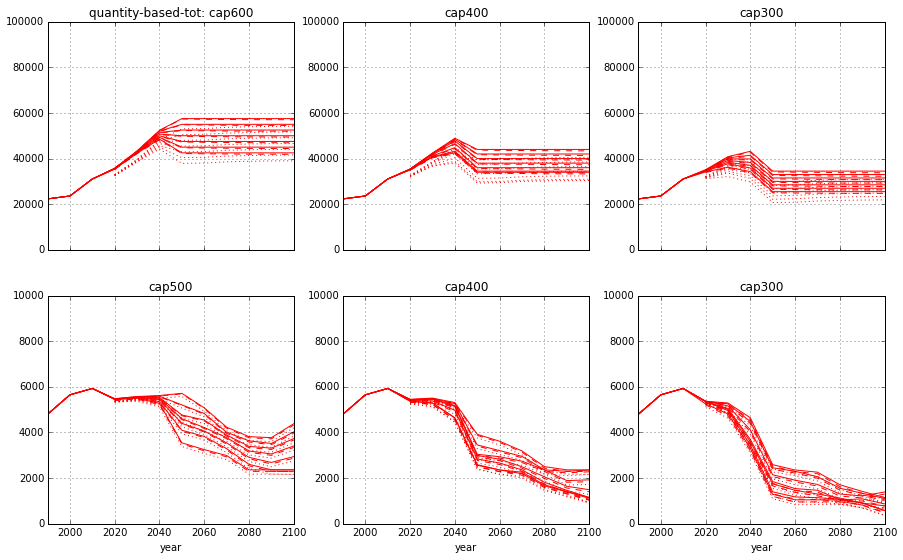

In [6]:
def q_plot(df1,df2,df3):
    for i in df1.columns.values:
        df1[i].plot(legend=False,color =color,linestyle='-')
    for i in df2.columns.values:
        df2[i].plot(legend=False,color =color,linestyle='--')
    for i in df3.columns.values:
        df3[i].plot(legend=False,color =color,linestyle=':')
    
fig = plt.figure(figsize=(15,9))

ax1  = fig.add_subplot(231)
q_plot(qglobal_tot_cap500,qglobal_fi_cap500,qglobal_fos_cap500)
ax1.set_title(CarbonAccounting +': cap500')
ax1.set_xlim(1990,2100)
ax1.set_ylim(0,100000)

ax1  = fig.add_subplot(232)
q_plot(qglobal_tot_cap400,qglobal_fi_cap400,qglobal_fos_cap400)
ax1.set_title('cap400')
ax1.set_xlim(1990,2100)
ax1.set_ylim(0,100000)

ax1  = fig.add_subplot(233)
q_plot(qglobal_tot_cap300,qglobal_fi_cap300,qglobal_fos_cap300)
ax1.set_title('cap300')
ax1.set_xlim(1990,2100)
ax1.set_ylim(0,100000)

ax1  = fig.add_subplot(234)
q_plot(qUS_tot_cap500,qUS_fi_cap500,qUS_fos_cap500)
ax1.set_title('cap500')
ax1.set_xlim(1990,2100)
ax1.set_ylim(0,10000)

ax1  = fig.add_subplot(235)
q_plot(qUS_tot_cap400,qUS_fi_cap400,qUS_fos_cap400)
ax1.set_title('cap400')
ax1.set_xlim(1990,2100)
ax1.set_ylim(0,10000)

ax1  = fig.add_subplot(236)
q_plot(qUS_tot_cap300,qUS_fi_cap300,qUS_fos_cap300)
ax1.set_title('cap300')
ax1.set_xlim(1990,2100)
ax1.set_ylim(0,10000)

fig.show()

(0, 350)

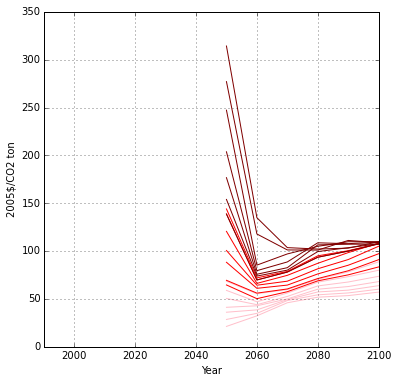

In [7]:

fig = plt.figure(figsize=(6,6))
ax1  = fig.add_subplot(111)
df1 = p_cap500
for i in df1.columns.values:
        df1[i].plot(legend=False,color ='pink',linestyle='-')
df1 = p_cap400
for i in df1.columns.values:
        df1[i].plot(legend=False,color ='red',linestyle='-')
df1 = p_cap300
for i in df1.columns.values:
        df1[i].plot(legend=False,color ='maroon',linestyle='-')
ax1.set_ylabel('2005$/CO2 ton')
ax1.set_xlabel('Year')
ax1.set_xlim(1990,2100)
ax1.set_ylim(0,350)

In the first batch (account all carbon in carbon cap), it makes sense to use all carbon emission as $q$. Here we do regression between $\log{p}$ and $\log{q}$ to measure elasticity. Note that MERGE is perfect foresight, so the carbon emission may change even though the carbon cap has not been assigned yet. Here we start measuring price elasticity of carbon emission in 2050.

Note that 60000 MMtCO2 cap is boring case where the cap is not stringent enough, so we omit it.

In [9]:
def constructelasticity_table(p,q):
    elasticity_table = pd.DataFrame(columns = ('year','value','lower','upper'))
    yearlist = [2050, 2060, 2070, 2080, 2090, 2100]
    for i in range(0,len(yearlist)):
        if np.array(p[p.index==yearlist[i]].isnull().sum(axis=1))==0:
            x = np.log10(np.array(p[p.index==yearlist[i]]))[0]
            y = np.log10(np.array(q[q.index==yearlist[i]]))[0]
            X = sm.add_constant(x)
            model = sm.OLS(y, X)
            results = model.fit()
            elasticity_table.loc[i] = [yearlist[i], results.params[1]]+list(results.conf_int()[1])
        else:
            elasticity_table.loc[i] = [yearlist[i], float('NaN'),float('NaN'),float('NaN')]
    return elasticity_table;


In [15]:
def accumulated_elasticity(p,q):
    x = np.log10(np.array(p[p.index>=2050].sum(axis=0)))
    #y = np.log10(np.array(q[q.index==yearlist[i]]))[0]
    y = np.log10(np.array(q[q.index>=2050].sum(axis=0)))
    X = sm.add_constant(x)
    model = sm.OLS(y, X)
    results = model.fit()
    l = [results.params[1]]+list(results.conf_int()[1])
    return [l[0],(l[2]-l[1])*0.5];

(-4, 0)

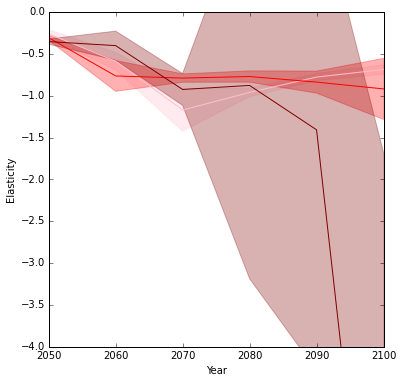

In [11]:
fig = plt.figure(figsize=(6,6))

ax1  = fig.add_subplot(111)
#ax1  = fig.add_subplot(211)

elasticity_table = constructelasticity_table(p_cap500,qglobal_tot_cap500)
ax1.plot(elasticity_table['year'],elasticity_table['value'],color='pink')
ax1.fill_between(np.array(list(elasticity_table['year'])),\
                 np.array(list(elasticity_table['lower'])),\
                 np.array(list(elasticity_table['upper'])), color='pink', alpha=0.3)   
elasticity_table = constructelasticity_table(p_cap400,qglobal_tot_cap400)
ax1.plot(elasticity_table['year'],elasticity_table['value'],color='red')
ax1.fill_between(np.array(list(elasticity_table['year'])),\
                 np.array(list(elasticity_table['lower'])),\
                 np.array(list(elasticity_table['upper'])), color='red', alpha=0.3)  
elasticity_table = constructelasticity_table(p_cap300,qglobal_tot_cap300)
ax1.plot(elasticity_table['year'],elasticity_table['value'],color='maroon')
ax1.fill_between(np.array(list(elasticity_table['year'])),\
                 np.array(list(elasticity_table['lower'])),\
                 np.array(list(elasticity_table['upper'])), color='maroon', alpha=0.3)          
ax1.set_ylabel('Elasticity')
ax1.set_xlabel('Year')
#ax1.set_title(CarbonAccounting +': global')
ax1.set_ylim(-4,0)

In [16]:
accumulated_elasticity(p_cap500,qglobal_tot_cap500)

[-0.64627521136971922, 0.017949211156212952]

In [17]:
accumulated_elasticity(p_cap400,qglobal_tot_cap400)

[-0.63018172031465802, 0.042839727964280927]

In [18]:
accumulated_elasticity(p_cap300,qglobal_tot_cap300)

[-0.75293628740231711, 0.03961561385840251]

## Alternative option: accounting fossil fuel carbon emission (FOS)

Second batch to account only fossil fuel carbon in cap is here. 

In [19]:
CarbonAccounting = 'quantity-based-fos' # 'price' vs. 'quantity' and 'tot' vs. 'fos'

#p_cap600, qUS_tot_cap600, qglobal_tot_cap600, qUS_fi_cap600, qglobal_fi_cap600, qUS_fos_cap600, qglobal_fos_cap600 = constructpq_table('cap600')
p_cap500, qUS_tot_cap500, qglobal_tot_cap500, qUS_fi_cap500, qglobal_fi_cap500, qUS_fos_cap500, qglobal_fos_cap500 = constructpq_table('cap500')
p_cap400, qUS_tot_cap400, qglobal_tot_cap400, qUS_fi_cap400, qglobal_fi_cap400, qUS_fos_cap400, qglobal_fos_cap400 = constructpq_table('cap400')
p_cap300, qUS_tot_cap300, qglobal_tot_cap300, qUS_fi_cap300, qglobal_fi_cap300, qUS_fos_cap300, qglobal_fos_cap300 = constructpq_table('cap300')

Here we plot all types of carbon emission with different perturbations under different step caps.

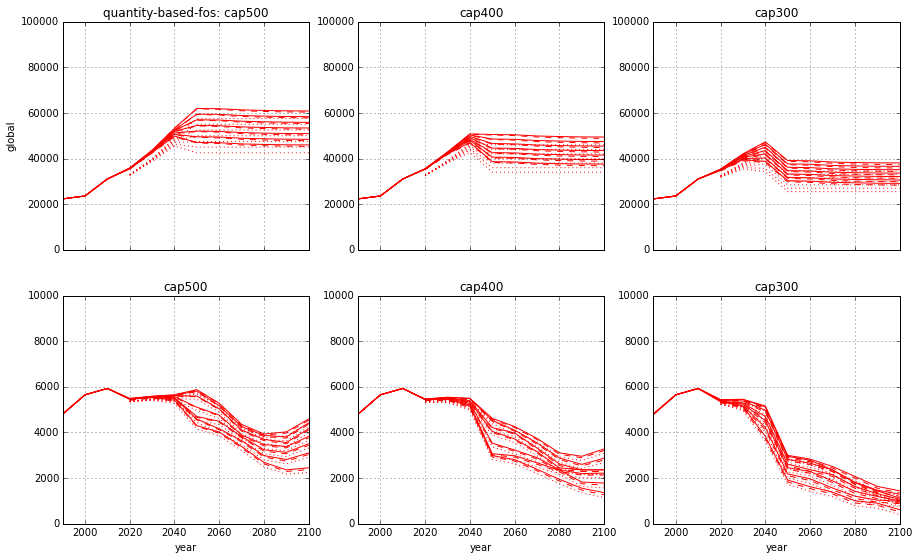

In [20]:
    
fig = plt.figure(figsize=(15,9))

ax1  = fig.add_subplot(231)
q_plot(qglobal_tot_cap500,qglobal_fi_cap500,qglobal_fos_cap500)
ax1.set_title(CarbonAccounting +': cap500')
ax1.set_ylabel('global')
ax1.set_xlim(1990,2100)
ax1.set_ylim(0,100000)

ax1  = fig.add_subplot(232)
q_plot(qglobal_tot_cap400,qglobal_fi_cap400,qglobal_fos_cap400)
ax1.set_title('cap400')
ax1.set_xlim(1990,2100)
ax1.set_ylim(0,100000)

ax1  = fig.add_subplot(233)
q_plot(qglobal_tot_cap300,qglobal_fi_cap300,qglobal_fos_cap300)
ax1.set_title('cap300')
ax1.set_xlim(1990,2100)
ax1.set_ylim(0,100000)

ax1  = fig.add_subplot(234)
q_plot(qUS_tot_cap500,qUS_fi_cap500,qUS_fos_cap500)
ax1.set_title('cap500')
ax1.set_xlim(1990,2100)
ax1.set_ylim(0,10000)

ax1  = fig.add_subplot(235)
q_plot(qUS_tot_cap400,qUS_fi_cap400,qUS_fos_cap400)
ax1.set_title('cap400')
ax1.set_xlim(1990,2100)
ax1.set_ylim(0,10000)

ax1  = fig.add_subplot(236)
q_plot(qUS_tot_cap300,qUS_fi_cap300,qUS_fos_cap300)
ax1.set_title('cap300')
ax1.set_xlim(1990,2100)
ax1.set_ylim(0,10000)

fig.show()

(0, 350)

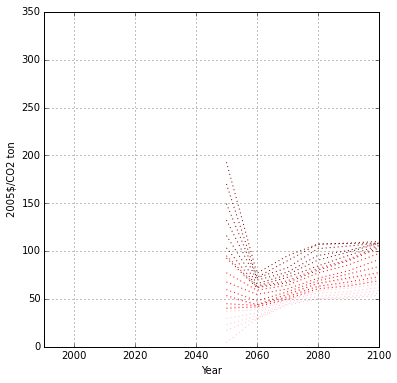

In [21]:

fig = plt.figure(figsize=(6,6))
ax1  = fig.add_subplot(111)
df1 = p_cap500
for i in df1.columns.values:
        df1[i].plot(legend=False,color ='pink',linestyle=':')
df1 = p_cap400
for i in df1.columns.values:
        df1[i].plot(legend=False,color ='red',linestyle=':')
df1 = p_cap300
for i in df1.columns.values:
        df1[i].plot(legend=False,color ='maroon',linestyle=':')
ax1.set_ylabel('2005$/CO2 ton')
ax1.set_xlabel('Year')
ax1.set_xlim(1990,2100)
ax1.set_ylim(0,350)

(-4, 0)

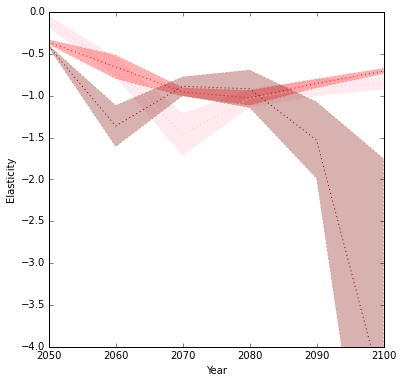

In [23]:
fig = plt.figure(figsize=(6,6))

ax1  = fig.add_subplot(111)
#ax1  = fig.add_subplot(211)

elasticity_table = constructelasticity_table(p_cap500,qglobal_fos_cap500)
ax1.plot(elasticity_table['year'],elasticity_table['value'],color='pink',linestyle=':')
ax1.fill_between(np.array(list(elasticity_table['year'])),\
                 np.array(list(elasticity_table['lower'])),\
                 np.array(list(elasticity_table['upper'])), color='pink',linestyle=':', alpha=0.3)   
elasticity_table = constructelasticity_table(p_cap400,qglobal_fos_cap400)
ax1.plot(elasticity_table['year'],elasticity_table['value'],color='red',linestyle=':')
ax1.fill_between(np.array(list(elasticity_table['year'])),\
                 np.array(list(elasticity_table['lower'])),\
                 np.array(list(elasticity_table['upper'])), color='red',linestyle=':', alpha=0.3)  
elasticity_table = constructelasticity_table(p_cap300,qglobal_fos_cap300)
ax1.plot(elasticity_table['year'],elasticity_table['value'],color='maroon',linestyle=':')
ax1.fill_between(np.array(list(elasticity_table['year'])),\
                 np.array(list(elasticity_table['lower'])),\
                 np.array(list(elasticity_table['upper'])), color='maroon',linestyle=':', alpha=0.3)          

ax1.set_ylabel('Elasticity')
ax1.set_xlabel('Year')
#ax1.set_title(CarbonAccounting +': global')
ax1.set_ylim(-4,0)

In [25]:
accumulated_elasticity(p_cap500,qglobal_fos_cap500)

[-0.68534047529665187, 0.03480178807158385]

In [27]:
accumulated_elasticity(p_cap400,qglobal_fos_cap400)

[-0.68828868701015722, 0.022482194003833889]

In [32]:
accumulated_elasticity(p_cap300,qglobal_fos_cap300)

[-0.90416081486148059, 0.056312228705143075]